# Impulse Response Function

In [148]:
library(tidyverse)
library(tsDyn) # Simulating var processes
library(vars)

options(repr.plot.width=8, repr.plot.height=2.5)

Important both models are limited in that they contain a identification restriction
$$ e_{1t} = \varepsilon_{yt} - b_{12}\varepsilon_{zt}$$
$$ e_{2t} = \varepsilon_{zt} $$
This means that there is no contemporary effect from $y_t$ to $z_t$ but only the other way round. In effect this is implemented as:
$$ e_{1t} = \varepsilon_{yt} + 0.8\varepsilon_{zt}$$
$$ e_{2t} = \varepsilon_{zt} $$

# First model - positive off-diagonal elements of $A_1$

$$
\begin{bmatrix} y_t \\ z_t \end{bmatrix}
=
\begin{bmatrix} 0.7 & 0.2 \\ 0.2 & 0.7 \end{bmatrix}
\cdot
\begin{bmatrix} y_{t-1} \\ z_{t-1} \end{bmatrix}
+
\begin{bmatrix} e_{1t} \\ e_{2t} \end{bmatrix}
$$

In [225]:
yt <- c(0)
zt <- c(0)
nsim <- 200

for (i in 2:nsim) {
    ey <- rnorm(1) 
    ez <- rnorm(1)
    yt[i] <- 0.7*yt[i-1] + 0.2*zt[i-1] + (0.8*ez + ey)
    zt[i] <- 0.7*zt[i-1] + 0.2*yt[i-1] + ez
}
sim <- cbind(zt, yt)
head(sim)

zt,yt
0.0000000,0.0000000
0.4522187,-1.2031459
0.6492724,-0.8101898
0.9373831,1.7080566
1.4292976,2.9731580
1.4562511,1.6986045


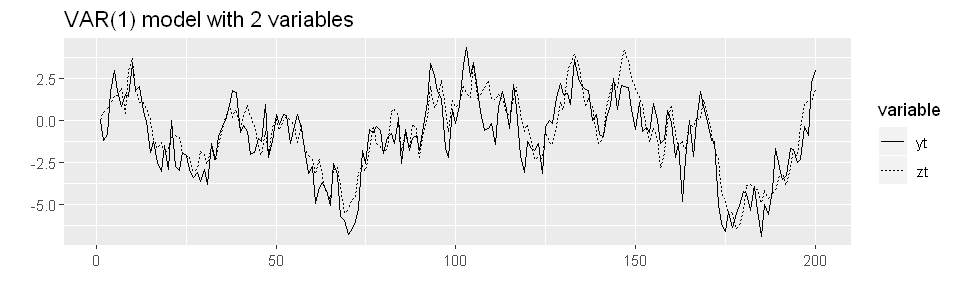

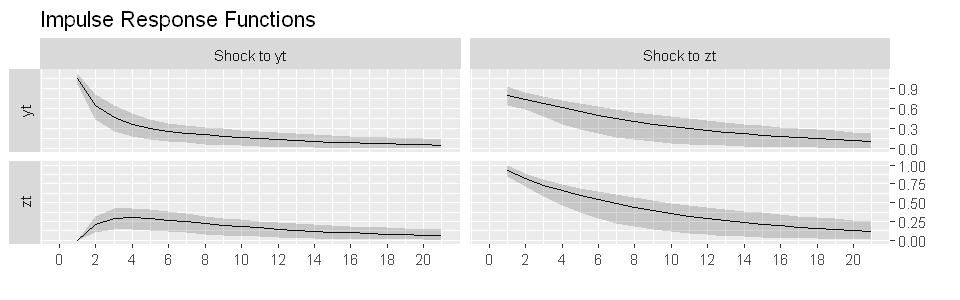

In [229]:
m <- VAR(sim, p = 1, type = "const")

psim <- as.data.frame(sim)
psim$n <- c(1:nsim)
psim <- gather(psim, variable, value, -n)

p1 <- ggplot(psim, aes(n, value, linetype=variable)) + 
 geom_line() + 
 labs(title="VAR(1) model with 2 variables", x="", y="")

data <- irf(m, nsteps = 12, n.ahead=20)
variables <- data$irf %>% names

#### Function to extract IRF data ####
ir <- lapply(1:length(variables), function(e){
    data_to_plot <- data.frame(data %>% `$`(irf) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Value, -t)

    upper_ci <- data.frame(data %>% `$`(Upper) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Upper, -t)

    lower_ci <- data.frame(data %>% `$`(Lower) %>% `[[`(variables[e]) ) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Lower, -t)

    res <- inner_join(data_to_plot, upper_ci, c("t","Variable")) %>%
           inner_join(.,lower_ci, c("t","Variable")) %>%
           mutate(impulse = paste("Shock to", variables[e])) 
}) %>% bind_rows
######################################

p2 <- ggplot(ir, aes(x = t, y = Value, group = Variable))  +
  geom_line() +
  geom_ribbon(aes(x=t, ymax=Upper, ymin=Lower), alpha=0.2) +
  scale_x_continuous(limits = c(0,21), breaks = seq(0,20,2)) +
  scale_y_continuous("", position="right") +
  labs(title="Impulse Response Functions", x="") +
  facet_grid(Variable ~ impulse, scales="free", switch="y")

print(p1)
print(p2)

In [221]:
m


VAR Estimation Results:

Estimated coefficients for equation zt: 
Call:
zt = zt.l1 + yt.l1 + const 

      zt.l1       yt.l1       const 
 0.72953089  0.14173619 -0.06726421 


Estimated coefficients for equation yt: 
Call:
yt = zt.l1 + yt.l1 + const 

       zt.l1        yt.l1        const 
 0.346840790  0.589497137 -0.005615127 



# Second model - negative off-diagonal elements of $A_1$

$$
\begin{bmatrix} y_t \\ z_t \end{bmatrix}
=
\begin{bmatrix} 0.7 & -0.2 \\ -0.2 & 0.7 \end{bmatrix}
\cdot
\begin{bmatrix} y_{t-1} \\ z_{t-1} \end{bmatrix}
+
\begin{bmatrix} e_{1t} \\ e_{2t} \end{bmatrix}
$$

In [226]:
yt <- c(0)
zt <- c(0)
nsim <- 200

for (i in 2:nsim) {
    ey <- rnorm(1) 
    ez <- rnorm(1)
    yt[i] <- 0.7*yt[i-1] - 0.2*zt[i-1] + (0.8*ez + ey)
    zt[i] <- 0.7*zt[i-1] - 0.2*yt[i-1] + ez
}
sim2 <- cbind(zt, yt)
head(sim2)

zt,yt
0.0000000,0.0000000
0.2611909,0.7640737
-0.4292164,0.3720584
-0.6105205,-0.8577699
-1.5067534,-0.6196351
-2.3681958,-0.6428335


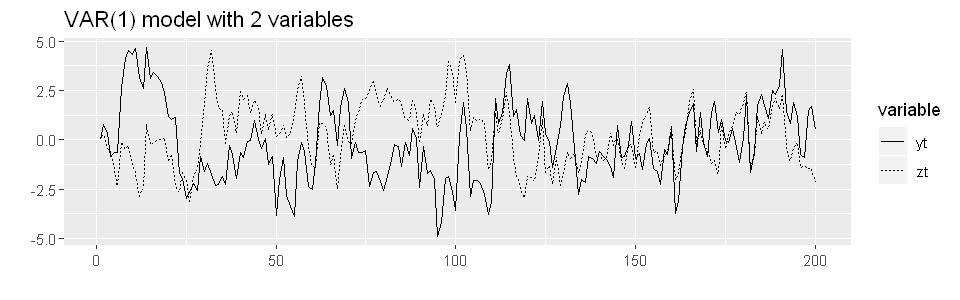

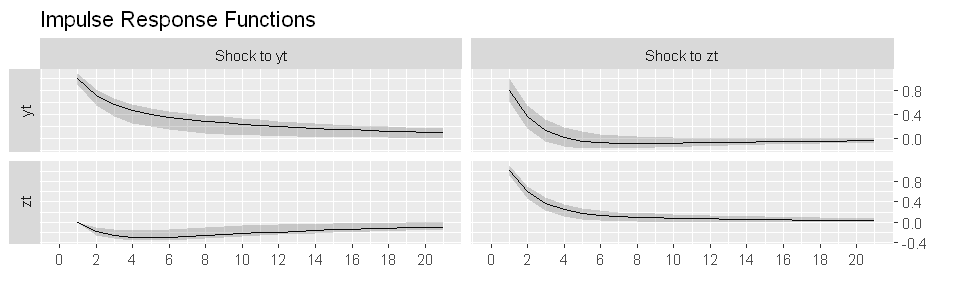

In [230]:
m <- VAR(sim2, p = 1, type = "const")

psim <- as.data.frame(sim2)
psim$n <- c(1:nsim)
psim <- gather(psim, variable, value, -n)

p3 <- ggplot(psim, aes(n, value, linetype=variable)) + 
 geom_line() + 
 labs(title="VAR(1) model with 2 variables", x="", y="")

data <- irf(m, nsteps = 12, n.ahead=20)
variables <- data$irf %>% names

#### Function to extract IRF data ####
ir <- lapply(1:length(variables), function(e){
    data_to_plot <- data.frame(data %>% `$`(irf) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Value, -t)

    upper_ci <- data.frame(data %>% `$`(Upper) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Upper, -t)

    lower_ci <- data.frame(data %>% `$`(Lower) %>% `[[`(variables[e]) ) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Lower, -t)

    res <- inner_join(data_to_plot, upper_ci, c("t","Variable")) %>%
           inner_join(.,lower_ci, c("t","Variable")) %>%
           mutate(impulse = paste("Shock to", variables[e])) 
}) %>% bind_rows
######################################

p4 <- ggplot(ir, aes(x = t, y = Value, group = Variable))  +
  geom_line() +
  geom_ribbon(aes(x=t, ymax=Upper, ymin=Lower), alpha=0.2) +
  scale_x_continuous(limits = c(0,21), breaks = seq(0,20,2)) +
  scale_y_continuous("", position="right") +
  labs(title="Impulse Response Functions", x="") +
  facet_grid(Variable ~ impulse, scales="free", switch="y")

print(p3)
print(p4)

In [224]:
m


VAR Estimation Results:

Estimated coefficients for equation zt: 
Call:
zt = zt.l1 + yt.l1 + const 

      zt.l1       yt.l1       const 
 0.71681439 -0.20681215  0.03664302 


Estimated coefficients for equation yt: 
Call:
yt = zt.l1 + yt.l1 + const 

       zt.l1        yt.l1        const 
-0.229861544  0.685698094  0.006068999 

